In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import processingIO as pio
import dataUtilities as du

from pathlib import Path

In [2]:
data_location = r'/media/mco143/2TB/OpenFOAM Simulations/Anderson_validation'
save_location = r'/media/mco143/2TB/OpenFOAM Simulations/Anderson_validation'

# Example path to the postProcessing folder
/path/to/simulation/files/backGround/postProcessing/---/0/data

--- is:

forceCoeffs_object --> forceCoeff

forces_object --> forces

solverInfo --> solverInfo

yplus --> yPlus

In [3]:
force_paths = pio.get_files(data_location, 'force.dat')
forceCoeff_paths = pio.get_files(data_location, 'coefficient.dat')
yPlus_paths = pio.get_files(data_location, 'yPlus.dat')
solverInfo_paths = pio.get_files(data_location, 'solverInfo.dat')

force_paths.sort()
force_sheets = [x.parts[-6] for x in force_paths]

forceCoeff_paths.sort()
forceCoeff_sheets = [x.parts[-6] for x in forceCoeff_paths]

yPlus_paths.sort()
yPlus_sheets = [x.parts[-6] for x in yPlus_paths]

solverInfo_paths.sort()
solverInfo_sheets = [x.parts[-6] for x in solverInfo_paths]

In [4]:
forceCoeff_save = pio.write_excel_files(save_location, forceCoeff_paths, forceCoeff_sheets, 'forceCoeff', 0.0, 20.0, None)
force_save = pio.write_excel_files(save_location, force_paths, force_sheets, 'forces', 0.0, 20.0, None)
yplus_save = pio.write_excel_files(save_location, yPlus_paths, yPlus_sheets, 'yPlus', 0.0, 20.0, 'wing')
solverInfo_save = pio.write_excel_files(save_location, solverInfo_paths, solverInfo_sheets, 'solverInfo', 0.0, 20.0, None)

In [18]:
# flags


forces = 1
forceCoeffs = 1
residuals = 0
yPluss = 1

number_cycles = 2
total_cycles = 3

density=998.2

# grab data based on flags
if(forces):
    force_data = pio.get_files(save_location, 'forces.xlsx')[0]
    force_time = []
    total_x = []
    total_y = []
    total_z = []
    force_period = []
    forceCoeff_period = []

    xl = pd.ExcelFile(Path(force_data))
    force_names = xl.sheet_names
    
    # gather data from excel sheet
    for i, name in enumerate(force_names):
        df = pd.read_excel(Path(force_data), sheet_name = name)
        cuttoff_time = df['Time'].values[-1]*(1.0/total_cycles)
        force_period.append(df['Time'].values[-1]/(total_cycles/number_cycles))
        
        data = df[df['Time'] > cuttoff_time]
        force_time.append(data['Time'].values)
        total_x.append(data['total_x'].values/density)
        total_y.append(data['total_y'].values/density)
        total_z.append(data['total_z'].values/density)

if(forceCoeffs):
    forceCoeff_data = pio.get_files(save_location, 'forceCoeff.xlsx')[0]
    forceCoeff_time = []
    Cd = []
    Cl = []
    xl = pd.ExcelFile(Path(forceCoeff_data))
    forceCoeff_names = xl.sheet_names
    
    for i, name in enumerate(forceCoeff_names):
        df = pd.read_excel(Path(forceCoeff_data), sheet_name = name)
        cuttoff_time = df['Time'].values[-1]*(1.0/total_cycles)
        forceCoeff_period.append(df['Time'].values[-1]/(total_cycles/number_cycles))
        
        data = df[df['Time'] > cuttoff_time]
        forceCoeff_time.append(data['Time'].values)
        Cd.append(data['Cd'].values/density)
        Cl.append(data['Cl'].values/density)

if(residuals):
    residual_data = pio.get_files(save_location, 'solverInfo.xlsx')[0]

    xl = pd.ExcelFile(Path(residual_data))
    residual_names = xl.sheet_names


if(yPluss):
    yPlus_data = pio.get_files(save_location, 'yPlus.xlsx')[0]
    yPlus_time = []
    yPlus_max = []
    yPlus_min = []
    yPlus_avg = []

    xl = pd.ExcelFile(Path(yPlus_data))
    yPlus_names = xl.sheet_names

    for i, name in enumerate(yPlus_names):
        df = pd.read_excel(Path(yPlus_data), sheet_name = name)
        cuttoff_time = df['Time'].values[-1]*(1.0/total_cycles)
        
        data = df[df['Time'] > cuttoff_time]
        yPlus_time.append(data['Time'].values)
        yPlus_min.append(data['min_yplus'].values)
        yPlus_max.append(data['max_yplus'].values)
        yPlus_avg.append(data['average_yplus'].values)

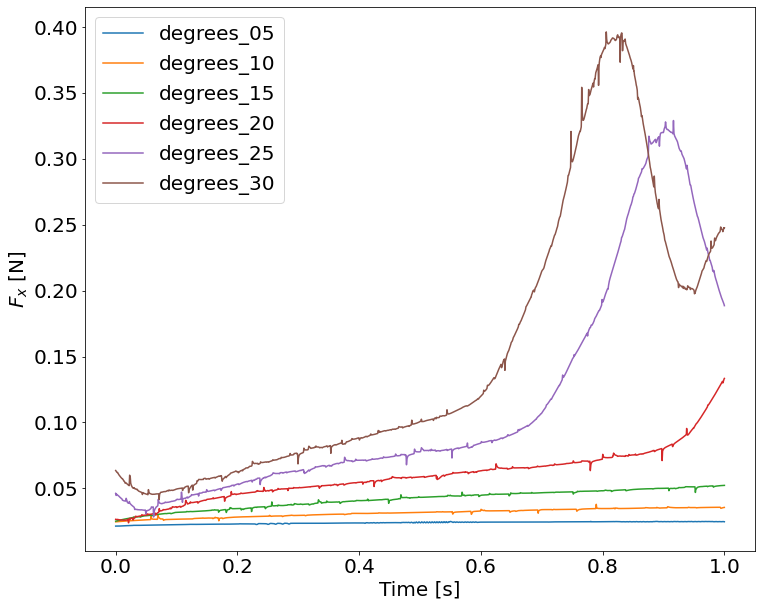

In [19]:
average_x = []

plt.rcParams.update({'font.size':20})
fig1, ax1 = plt.subplots(figsize=(12,10))
for i, names in enumerate(force_names):
    filtered_force = du.filterData(total_x[i], kernelLength=11, kernelFunction='hanning')
    x = np.linspace(force_time[i][0], force_time[i][-1], len(filtered_force))
    filtered_force = np.interp(force_time[i], x, filtered_force)
    average_x.append(np.mean(filtered_force))
    ax1.plot((force_time[i]-force_time[i][0])/force_period[i], filtered_force, label=force_names[i])

ax1.set_ylabel('$F_x$ [N]')
ax1.set_xlabel('Time [s]')
ax1.legend()

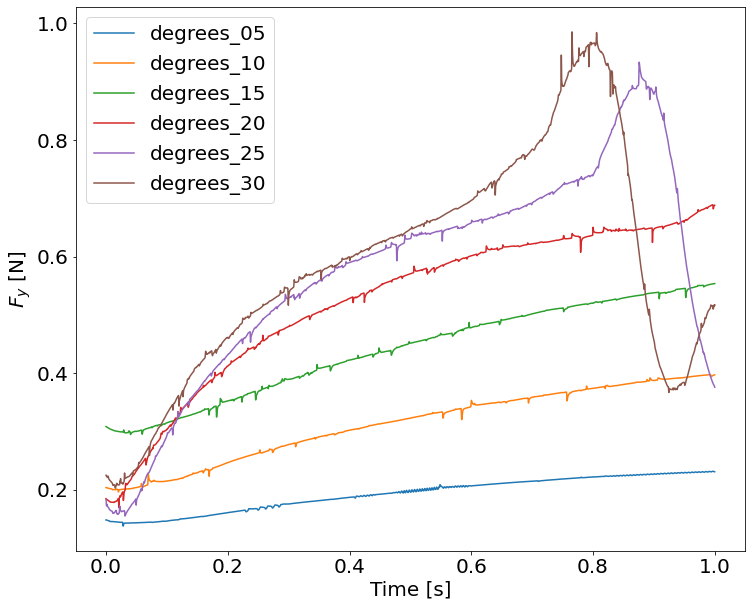

In [20]:
average_y = []

fig2, ax2 = plt.subplots(figsize=(12,10))
for i, names in enumerate(force_names):
    filtered_force = du.filterData(total_y[i], kernelLength=11, kernelFunction='hanning')
    x = np.linspace(force_time[i][0], force_time[i][-1], len(filtered_force))
    filtered_force = np.interp(force_time[i], x, filtered_force)
    average_y.append(np.mean(filtered_force))
    ax2.plot((force_time[i]-force_time[i][0])/force_period[i], filtered_force, label=force_names[i])

ax2.set_ylabel('$F_y$ [N]')
ax2.set_xlabel('Time [s]')
ax2.legend()

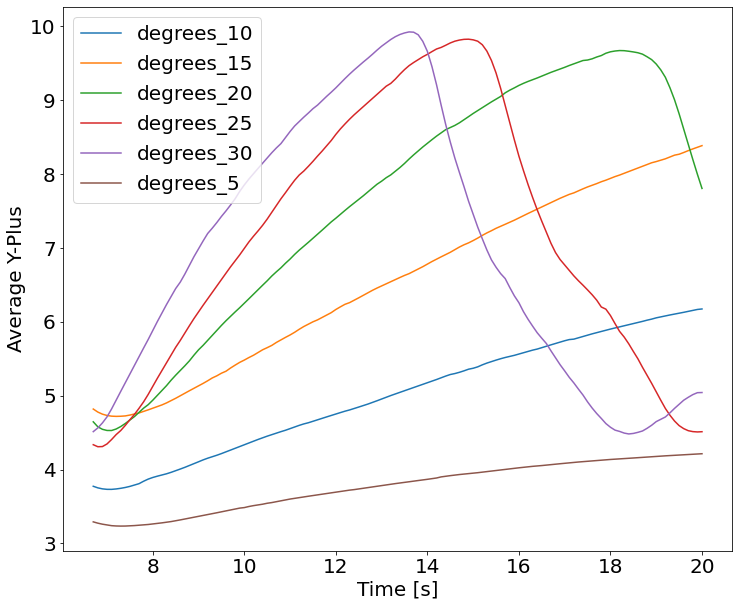

In [21]:
fig3, ax3 = plt.subplots(figsize=(12,10))
for i, names in enumerate(yPlus_names):
    ax3.plot(yPlus_time[i], yPlus_avg[i], label=yPlus_names[i])

ax3.set_ylabel('Average Y-Plus')
ax3.set_xlabel('Time [s]')
ax3.legend()

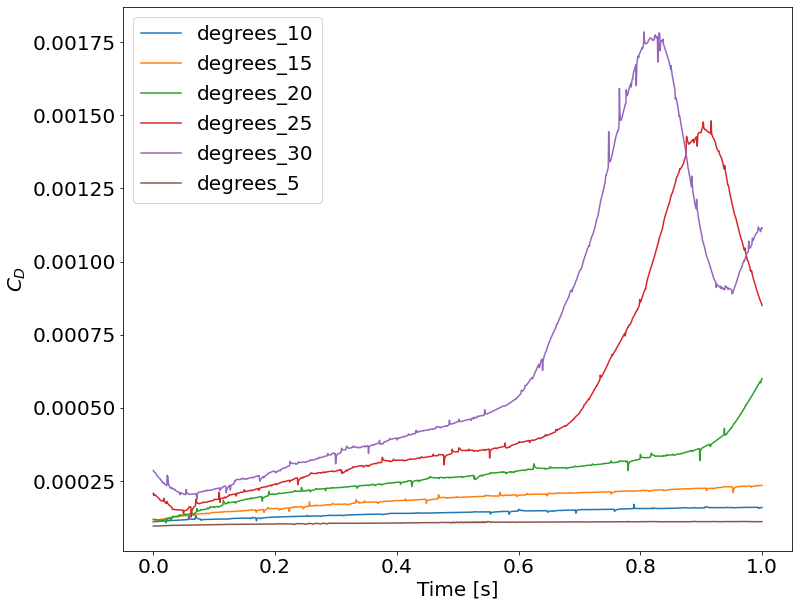

In [22]:
fig4, ax4 = plt.subplots(figsize=(12,10))
for i, names in enumerate(forceCoeff_names):
    filtered_force = du.filterData(Cd[i], kernelLength=11, kernelFunction='hanning')
    x = np.linspace(forceCoeff_time[i][0], forceCoeff_time[i][-1], len(filtered_force))
    filtered_force = np.interp(forceCoeff_time[i], x, filtered_force)
    average.append(np.mean(filtered_force))
    ax4.plot((forceCoeff_time[i]-forceCoeff_time[i][0])/forceCoeff_period[i], filtered_force, label=forceCoeff_names[i])

ax4.set_ylabel('$C_D$')
ax4.set_xlabel('Time [s]')
ax4.legend()

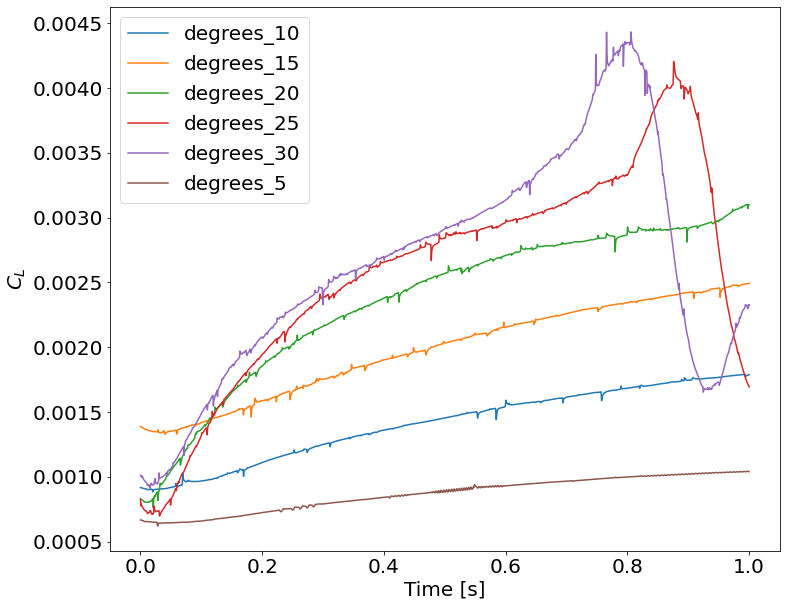

In [23]:
fig5, ax5 = plt.subplots(figsize=(12,10))
for i, names in enumerate(forceCoeff_names):
    filtered_force = du.filterData(Cl[i], kernelLength=11, kernelFunction='hanning')
    x = np.linspace(forceCoeff_time[i][0], forceCoeff_time[i][-1], len(filtered_force))
    filtered_force = np.interp(forceCoeff_time[i], x, filtered_force)
    average.append(np.mean(filtered_force))
    ax5.plot((forceCoeff_time[i]-forceCoeff_time[i][0])/forceCoeff_period[i], filtered_force, label=forceCoeff_names[i])

ax5.set_ylabel('$C_L$')
ax5.set_xlabel('Time [s]')
ax5.legend()

In [24]:
error_x = []
error_y = []

for i, name in enumerate(force_names):
    error_x.append(np.abs(np.mean(total_x[i]) - np.mean(total_x[-1]/np.mean(total_x[-1]))))
    error_y.append(np.abs(np.mean(total_y[i]) - np.mean(total_y[-1])/np.mean(total_y[-1])))

Text(0, 0.5, 'Average $F_x$')

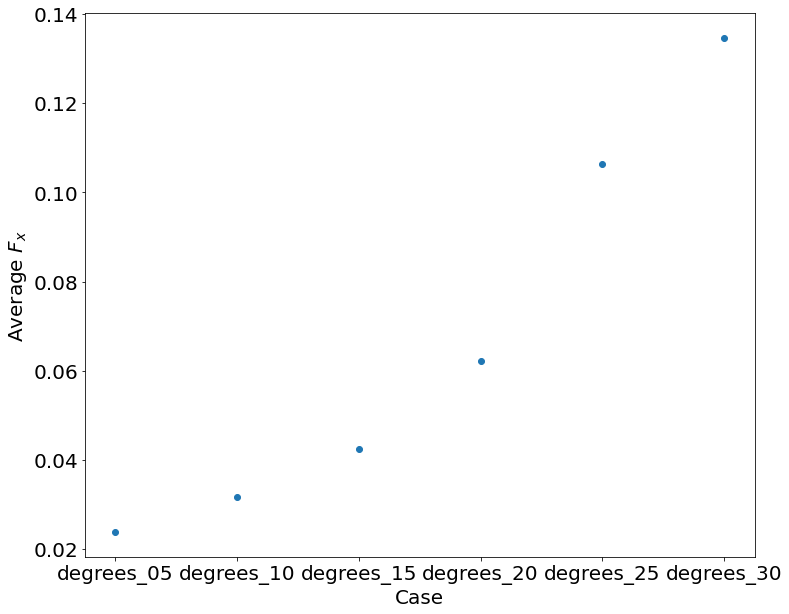

In [36]:
fig6, ax6 = plt.subplots(figsize=(12, 10))
ax6.plot(force_names, average_x, 'o')
ax6.set_xlabel("Case")
ax6.set_ylabel('Average $F_x$')